# Text Detection

- evaluate text detection models
- EAST text detector <https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/>
- CTPN https://github.com/eragonruan/text-detection-ctpn/
- deep text detection <https://github.com/opencv/opencv_contrib/blob/master/modules/text/samples/deeptextdetection.py>

In [18]:
%reload_ext autoreload
%autoreload 2
import os, sys
from os.path import join
import time
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob

import numpy as np
import imutils
import cv2 as cv

# append notebook imports folder
sys.path.append(str(Path(os.getcwd()).parent))
from utils import imx

# append vframe imports folder
sys.path.append(str(Path(os.getcwd()).parent.parent/'vframe/'))
from vframe.utils import im_utils, file_utils
from vframe.settings import vframe_cfg as cfg

In [19]:
# get a test image
im_test_list = glob(join(cfg.DIR_TEST_IMAGES, 'ocr', '*'))
print('found {} images'.format(len(im_test_list)))

found 16 images


## Deep Text Detection (OpenCV Demo)

In [20]:
# setup model
fp_model = join(cfg.DIR_MODELS_CAFFE, 'deepscenetext', "TextBoxes_icdar13.caffemodel")
fp_prototxt = join(cfg.DIR_MODELS_CAFFE, 'deepscenetext', 'textbox.prototxt')
#textSpotter = cv.text.TextDetectorCNN_create("textbox.prototxt", )
net = cv.text.TextDetectorCNN_create(fp_prototxt, fp_model)


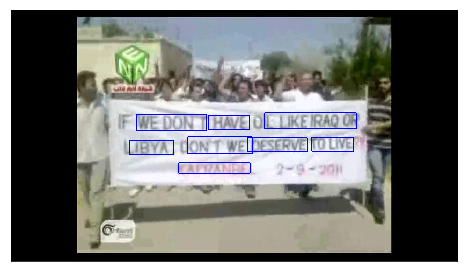

<Figure size 432x288 with 0 Axes>

In [26]:
# get random image
fp_im_test = np.random.choice(im_test_list)
# load
im = cv.imread(fp_im_test)
# detect
rects, probs = net.detect(im)
vis = im.copy()
thresh = 0.3
# draw
for r in range(np.shape(rects)[0]):
  if probs[r] > thresh:
    rect = rects[r]
    cv.rectangle(vis, (rect[0],rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (255, 0, 0), 2)
# display
imx.pltimg(vis, mode='bgr')

# EAST Text Detector

In [ ]:
import imutils
from imutils.object_detection import non_max_suppression

In [31]:
fp_model = join(cfg.DIR_MODELS_TF, 'east', 'frozen_east_text_detection.pb')
net = cv.dnn.readNetFromTensorflow(fp_model)

In [39]:
layerNames = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]

ignore: 2.8402814677974675e-06
ignore: 3.1661098631730056e-08
ignore: 4.8956061426963515e-09
ignore: 7.383678668482219e-10
ignore: 3.501373913028516e-10
ignore: 4.4063228066271165e-10
ignore: 4.5353248934176804e-10
ignore: 3.383603952578085e-10
ignore: 5.762030852451971e-10
ignore: 2.305157620341447e-09
ignore: 1.2516948366680936e-08
ignore: 2.490997452753163e-08
ignore: 2.6050765100649187e-08
ignore: 2.309286450952186e-08
ignore: 4.473472259292066e-08
ignore: 4.482474125211411e-08
ignore: 6.285497988756106e-08
ignore: 6.317240064390717e-08
ignore: 6.365863924884252e-08
ignore: 6.109579686608413e-08
ignore: 5.6697402328609314e-08
ignore: 5.3797386101450684e-08
ignore: 4.9304674121231074e-08
ignore: 4.650352991575346e-08
ignore: 4.729282565563153e-08
ignore: 4.3293013618495024e-08
ignore: 3.477563126352834e-08
ignore: 2.2910795038910692e-08
ignore: 1.3026767220480906e-08
ignore: 1.8337150464731167e-08
ignore: 7.836855075993299e-08
ignore: 2.6397896135677e-07
ignore: 2.6461364655006037e-

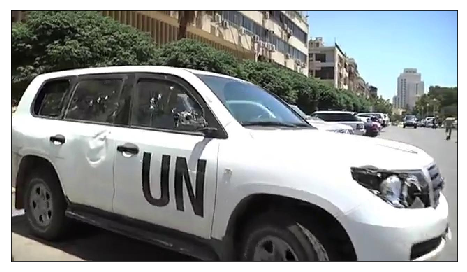

<Figure size 432x288 with 0 Axes>

In [72]:
# get random image
fp_im_test = np.random.choice(im_test_list)
# load
im = cv.imread(fp_im_test)
orig = im.copy()
(H, W) = im.shape[:2]

# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (320, 320)
rW = W / float(newW)
rH = H / float(newH)

# resize the image and grab the new image dimensions
im = cv.resize(im, (newW, newH))
(H, W) = im.shape[:2]


blob = cv.dnn.blobFromImage(im, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)

net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
# inference

(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []
 
# loop over the number of rows
for y in range(0, numRows):
  # extract the scores (probabilities), followed by the geometrical
  # data used to derive potential bounding box coordinates that
  # surround text
  scoresData = scores[0, 0, y]
  xData0 = geometry[0, 0, y]
  xData1 = geometry[0, 1, y]
  xData2 = geometry[0, 2, y]
  xData3 = geometry[0, 3, y]
  anglesData = geometry[0, 4, y]


# loop over the number of columns
for x in range(0, numCols):
  # if our score does not have sufficient probability, ignore it
  if scoresData[x] < 0.5:
    print('ignore: {}'.format(scoresData[x]))
    continue

  # compute the offset factor as our resulting feature maps will
  # be 4x smaller than the input image
  (offsetX, offsetY) = (x * 4.0, y * 4.0)

  # extract the rotation angle for the prediction and then
  # compute the sin and cosine
  angle = anglesData[x]
  cos = np.cos(angle)
  sin = np.sin(angle)

  # use the geometry volume to derive the width and height of
  # the bounding box
  h = xData0[x] + xData2[x]
  w = xData1[x] + xData3[x]

  # compute both the starting and ending (x, y)-coordinates for
  # the text prediction bounding box
  endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
  endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
  startX = int(endX - w)
  startY = int(endY - h)

  # add the bounding box coordinates and probability score to
  # our respective lists
  rects.append((startX, startY, endX, endY))
  confidences.append(scoresData[x])

# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
print(rects)
boxes = non_max_suppression(np.array(rects), probs=confidences)
 
# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
  # scale the bounding box coordinates based on the respective
  # ratios
  print(startX)
  startX = int(startX * rW)
  startY = int(startY * rH)
  endX = int(endX * rW)
  endY = int(endY * rH)

  # draw the bounding box on the image
  cv.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

  
imx.pltimg(orig, mode='bgr')
